# Сборный проект 2

# Введение и описание задачи

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.


Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 


У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 


Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Импортируем все необходимые библиотеки

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from matplotlib import pyplot as plt 
import phik
import seaborn as sns
import shap
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind



# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer, r2_score,mean_absolute_error,f1_score,confusion_matrix 


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import  SelectKBest, f_classif

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#Фиксируем константу для рандомизации
RANDOM_STATE = 42

# Задача 1: предсказание уровня удовлетворённости сотрудника

# Шаг 1. Загрузка данных

Сначала выгрузим основную таблицу

In [4]:
train_job_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

In [5]:
train_job_satisfaction.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3852,176885,hr,junior,low,2,no,no,5,16800,0.83
3724,910648,technology,junior,low,5,no,no,5,19200,0.75
3455,411262,technology,middle,medium,5,no,no,3,43200,0.35
197,605472,sales,junior,medium,2,no,no,4,25200,0.77
2725,738935,sales,junior,medium,4,no,yes,3,21600,0.13


In [6]:
train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
train_job_satisfaction.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Всего в таблице 4тыс записей, среди них есть несколько пропусков, нужно будет их поправить

Далее выгрузим входные признаки тестовой выборки

In [8]:
test_features =pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

In [9]:
test_features.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
100,781112,technology,junior,low,1,no,no,3,14400
411,306487,marketing,middle,medium,7,no,no,3,44400
1304,207434,hr,junior,medium,1,no,no,3,22800
365,109800,sales,middle,medium,7,no,no,3,36000
1101,223840,sales,junior,medium,2,no,no,2,24000


In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В тестовой выборке есть три пропуска - нужно будет это учесть

In [11]:
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [12]:
test_target_job_satisfaction_rate.sample(5)

,id,job_satisfaction_rate
1092,507655,0.56
101,935810,0.11
658,642991,0.56
300,873187,0.49
1651,859408,0.70


In [13]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Здесь всё в порядке

Выводы

В процессе загрузки данных были выгружены 3 таблицы. В первой таблице содержится 4 тыс записей о клиентах и их характеристиках. Есть несколько пропусков в столбцах dept и level, которые будем заполнять дальше. Далее идут тестовые данные о тех же характеристиках новых клиентах, также есть пару пропусков в тех же столбцах. Далее файл с целевым признаком (удволетворённость клиента) - пропуски отсутствуют. Большинство признаков в таблицах - категориальные.

# Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

Основное, что стоит сделать в предобработке: заполнение пропусков, устранение дубликатов и приведение данных к необходимому типу. Устранение пропусков оставим на пайплайн

In [14]:
train_job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Название всех столбцов имеет змеиный регистр, данные выглядят правдоподобно и соответсвтвуют описанию задачи, посмотрим в каких столбцах наблюдаются пропуски

In [15]:
train_job_satisfaction.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Несколько пропусков в категориальных признаках - устраним их в пайплайне. Посмотрим на тип данных каждого столбца

In [16]:
train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Все типы сходятся, теперь посмотрим на наличие явных / неявных дубликатов

In [17]:
train_job_satisfaction.duplicated().sum()

0

Явных дубликатов нет, посмотри на неявные, посмотрим на уникальные значения в столбцах dept, level, workload

In [18]:
for col in ['dept','level','workload']:
    print(train_job_satisfaction[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']


В целом неявных дубликатов также не наблюдается, появились наши пропуски, в целом данные из первой таблицы можно больше не трогать, посмотрим на тестовые данные

In [19]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [20]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [21]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [22]:
for col in ['dept','level','workload','last_year_promo','last_year_violations']:
    print(test_features[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


А вот в тестовых данных есть значения-пробелы, их необходимо превратить в тип nan

In [23]:
for col in ['dept','level','workload']:
    test_features[col] = test_features[col].replace([' '],np.nan)
    print(test_features[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]


In [24]:
test_features.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [25]:
test_features.duplicated().sum()

0

Осталось посомтреть на последний датасет с целвым признаком тестовой выборки

In [26]:
test_target_job_satisfaction_rate.sample(5)

,id,job_satisfaction_rate
1228,959945,0.63
1900,970176,0.70
1868,972727,0.30
1633,231731,0.39
1327,696102,0.69


In [27]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Здесь никаких проблем - двигаемся дальше. Заполнение пропусков я занялся на 4 шаге, так как при исследовательском анализе данных вышло, что некоторые признаки мультиколлинеарны, и их нужно убрать

# Шаг 3. Исследовательский анализ данных

Будет включать два шага - исследование распределения признаков и корреляционный анализ признаков

Сначала разберемся с основной таблицей посмотрим на распределение признаков

Чтобы далее не было проблем установим столбец id в качестве индекса

In [28]:
train_job_satisfaction = train_job_satisfaction.set_index('id')
train_job_satisfaction.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11


In [29]:
bar_cols = ['dept','level','last_year_promo','last_year_violations','employment_years','supervisor_evaluation']
hist_cols = ['salary','job_satisfaction_rate']

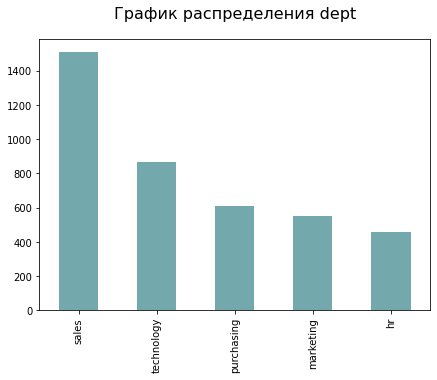

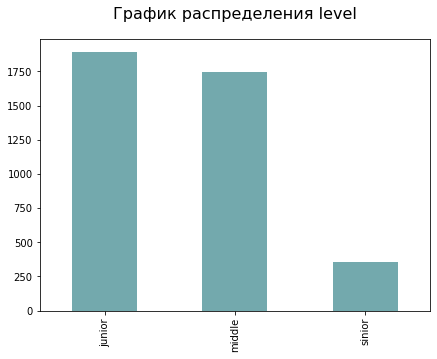

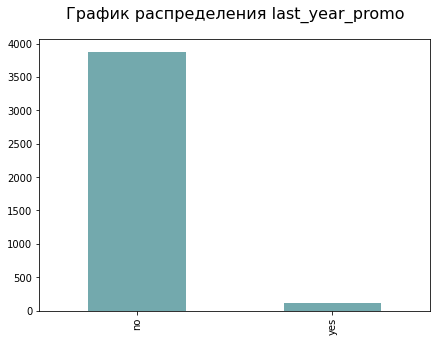

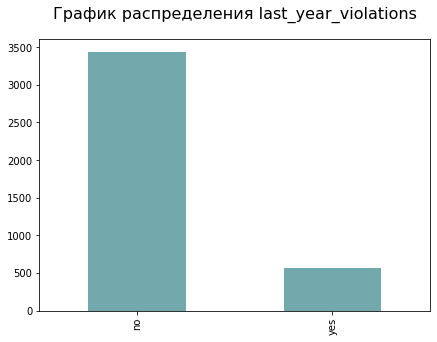

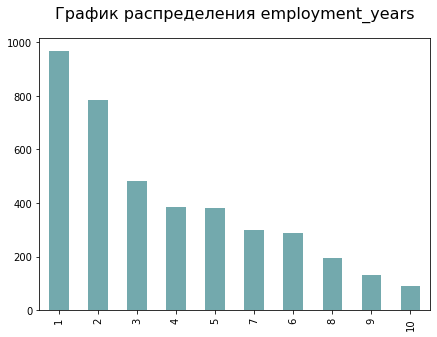

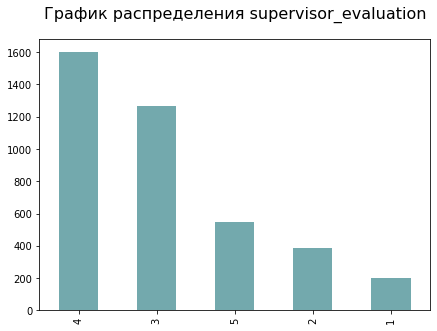

In [30]:
for col in bar_cols:
    train_job_satisfaction[col].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

По данным диаграмма можно сказать, что большинство работников находится в отделе продаж, работников уровня senior самое маленькое количество, также количество повышений и нарушений договора незначительное.

In [31]:
test_features.duplicated().sum()

0

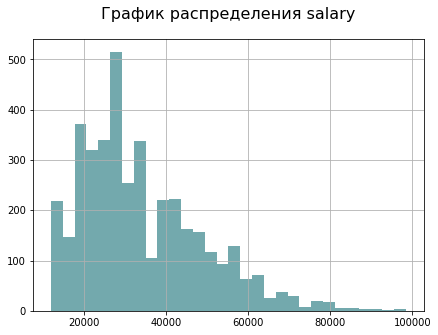

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


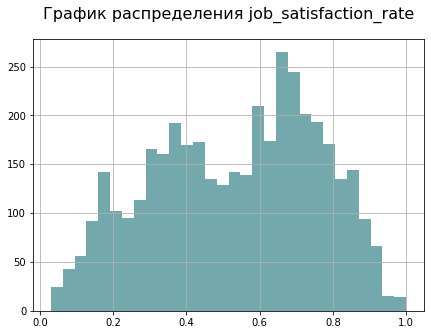

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [32]:
for col in hist_cols:
    train_job_satisfaction[col].hist(bins=30,figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()
    print(train_job_satisfaction[col].describe())

Распределние зарплат напоминает биномиальное с небольшим количеством выбросов, которые смещают среднее (34 тыс) вправо, в графике рапспределения удовлетворённости есть три пика

employment_years
supervisor_evaluation
salary


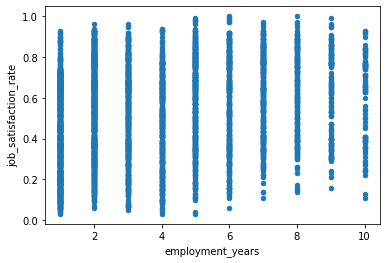

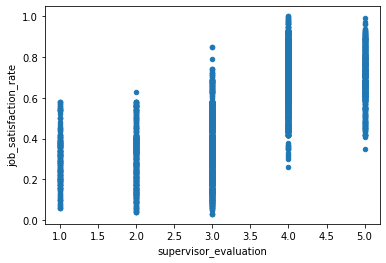

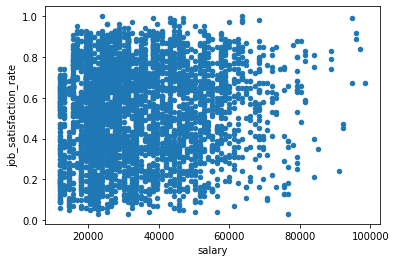

In [33]:
cols = ['employment_years','supervisor_evaluation','salary']
for col in cols:
    print(col)
    train_job_satisfaction.plot(kind='scatter',x=col, y='job_satisfaction_rate')
    #plt.title(f'График рассеяния для {col}')
    #plt.show()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


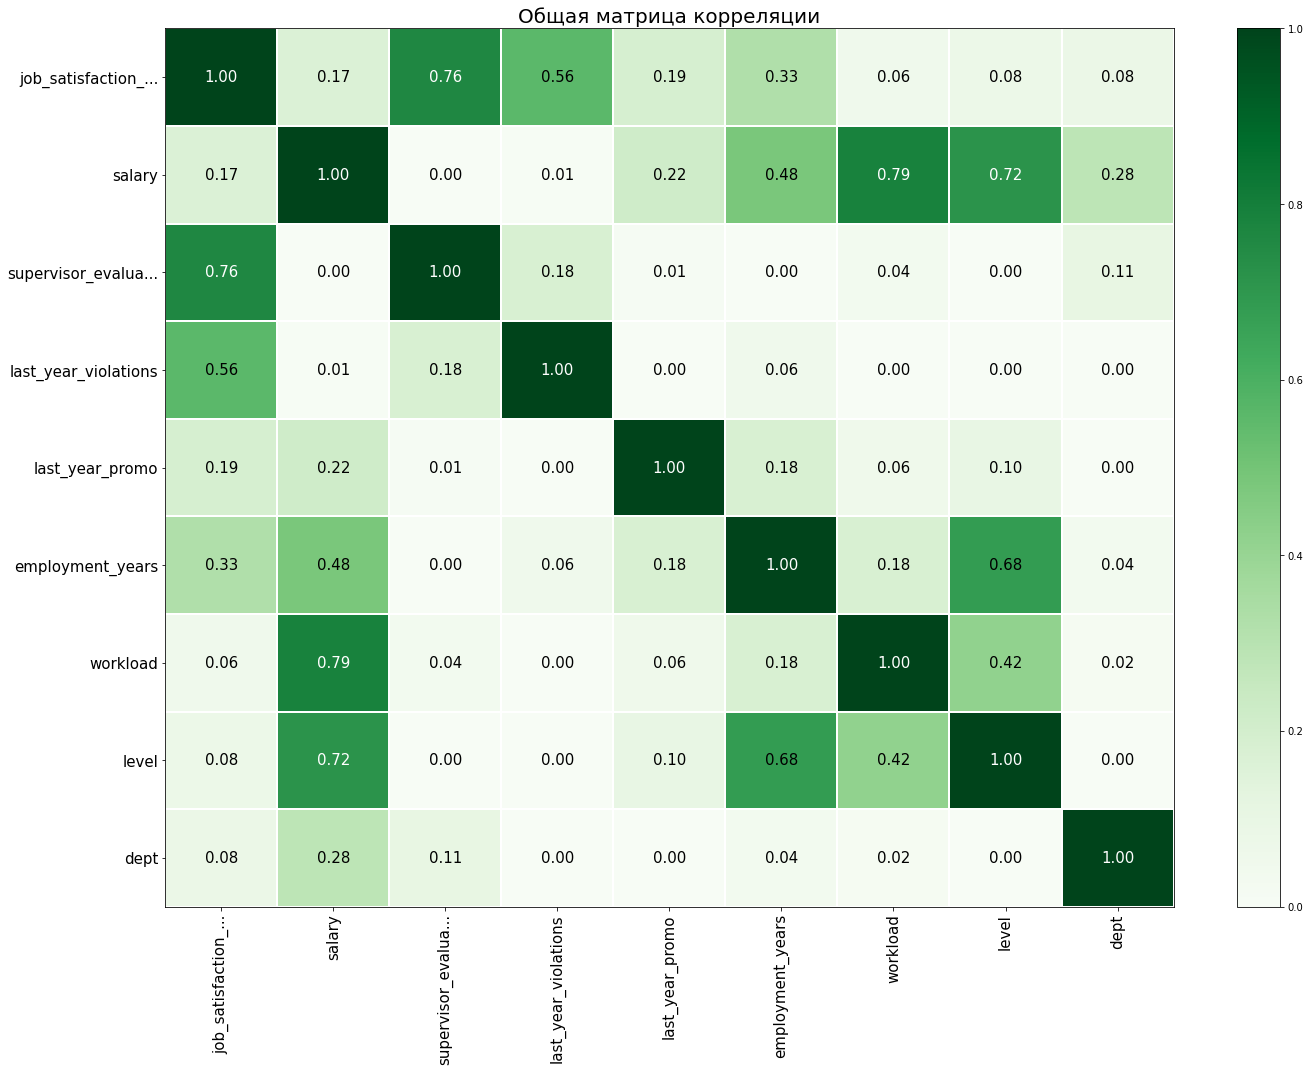

In [34]:
phik_matrix = train_job_satisfaction.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции',size=20)
plt.show()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


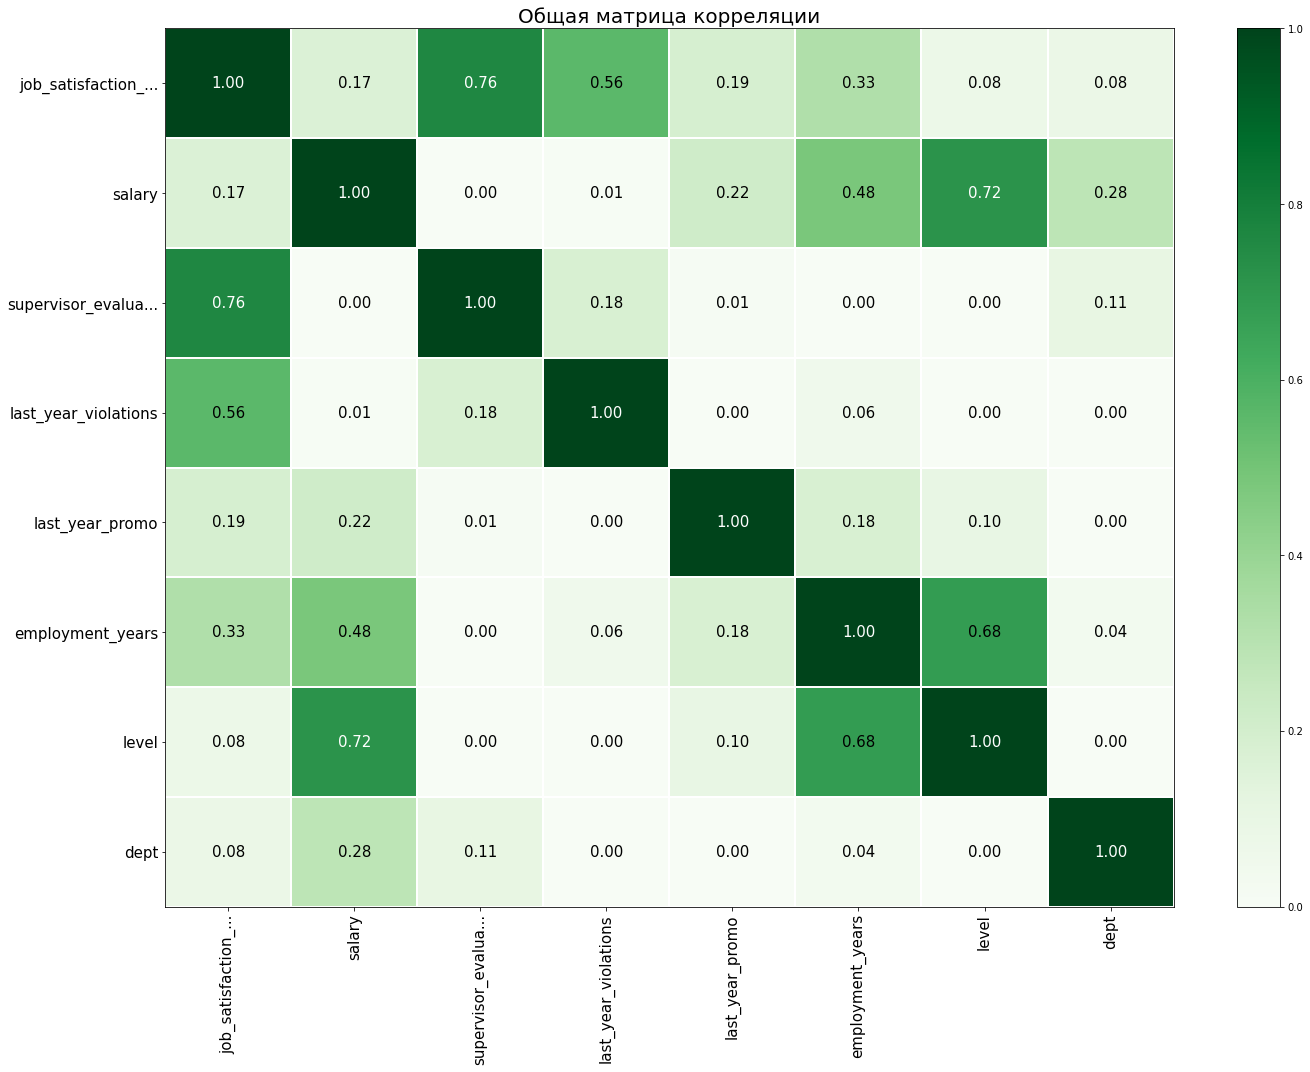

In [35]:
phik_matrix = train_job_satisfaction.drop(['workload'],axis=1).phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции',size=20)
plt.show()

Посмотрим на рспределение признаков на тестовой выборке

In [36]:
test_features.duplicated().sum()

0

In [37]:
test_features = test_features.set_index('id')
test_features.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200


In [38]:
test_features.duplicated().sum() #Появление дубликатов, но это не они - id разный!

557

In [39]:
bar_cols = ['dept','level','last_year_promo','last_year_violations','employment_years','supervisor_evaluation']

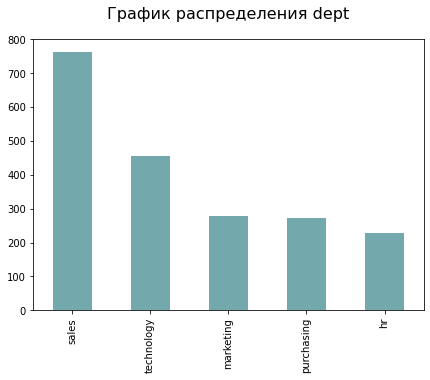

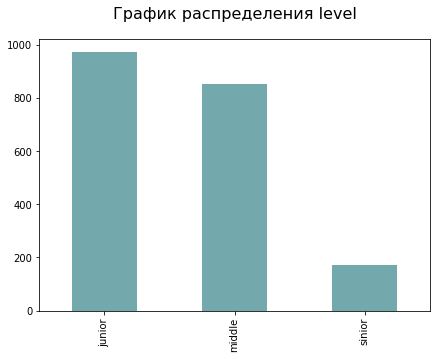

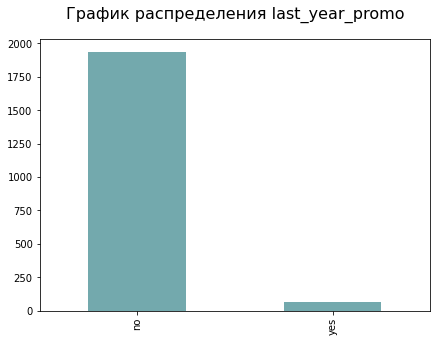

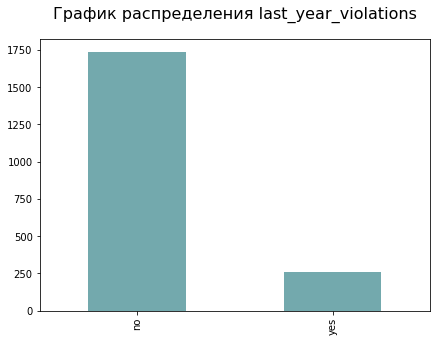

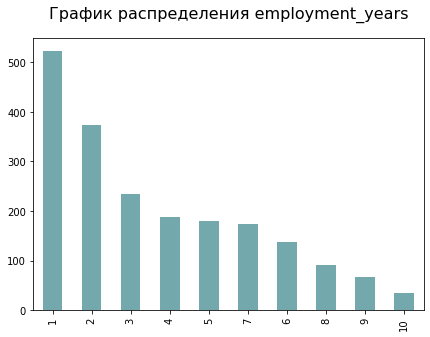

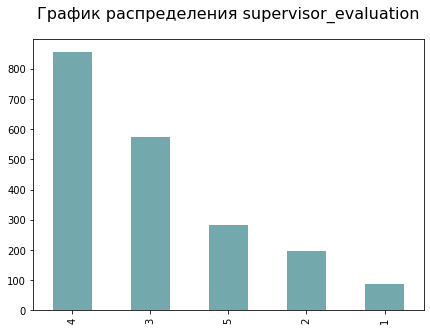

In [40]:
for col in bar_cols:
    test_features[col].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

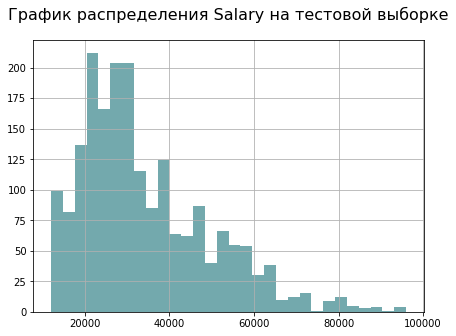

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [41]:
test_features['salary'].hist(bins=30,figsize=(7,5),color='#73A9AD')
plt.title(f'График распределения Salary на тестовой выборке',size=16,pad=20)
plt.show()
print(test_features['salary'].describe())

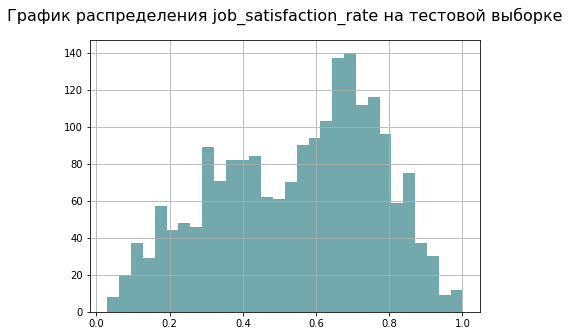

In [42]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].hist(bins=30,figsize=(7,5),color='#73A9AD')
plt.title(f'График распределения job_satisfaction_rate на тестовой выборке',size=16,pad=20)
plt.show()

In [43]:
train_X_features = train_job_satisfaction.drop(['workload'],axis=1)

In [44]:
train_job_satisfaction.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [45]:
test_features.duplicated().sum()

557

In [46]:
train_job_satisfaction['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

#### Выводы
На основе исследовательского нализа можно сказать следующее:

* У нас есть несколько категориальных номинальных признака dept, last_year_promo, last_year_violations
* Категориальных ранговых level, workload
* Количественных salary, job_satisfaction_rate (целевой признак)
* Количественные равнговые, которые можно не кодировать employment_years, supervisor_evaluation

Распределение признака salary похоже на биномальное с несколькими выбросами (высокие зп немногочисленных сотрудников), распределние по удовлетворённости также напоминает биномальное. 
При корреляционном анализе выяснилось, что сильная корреляция есть между признаками salary и workout, а также между salary и level (меньше). Для устранения мультиколлинеарности я убрал признак workout

# Шаг 4. Подготовка данных


Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

Объединим тестовые данные вместе по id

In [47]:
test_target = test_target_job_satisfaction_rate.set_index('id')

In [48]:
test_data =  test_features.drop(['workload'],axis=1).join(test_target)

In [49]:
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level']
num_columns = ['salary']

In [50]:
train_X_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [51]:

#Кодировщик номинальных категориальных признаков
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',sparse=False))
    
])

#Кодировщик ранговых категориальных признаков
ord_pipe = Pipeline(
[
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',OrdinalEncoder(categories=[
        ['junior','middle','sinior']], handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

#Пайплайн предобработки данных
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)
],
remainder='passthrough')


# Шаг 5. Обучение моделей

Создадим три различные модели и три различных сетки параметров для каждой модели - это важно для того, что метрики могут оказаться схожими, а вот алгоритм и объяснение результата разное и у лучшей модели по метрике, которая может отличаться на пару процентов от другой объяснение может не отражать реальность. Позже в этом нам поможет разобраться признаковое описание и интерпретация модели - важный этап

In [52]:
pipe_final = Pipeline(
[
    ('preprocessor',data_preprocessor),
    ('models',LinearRegression())
])

param_grid_linear = [
    {
    'models':[LinearRegression()],
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),RobustScaler()]
    }
]

param_grid_tree = [
    { 'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth':range(2,11),
     'models__min_samples_split':range(2,8),
     'preprocessor__num':[StandardScaler(),MinMaxScaler(),RobustScaler()]   
     }
]


param_grid_forest = [
    {
      'models':[RandomForestRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num':[StandardScaler(),MinMaxScaler(),RobustScaler()]    
    }
]



In [53]:
def smape_unweighted(y_true, y_pred):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2 + 0.000000001
    result = (error / scale).mean()*100
    return result
scorer = make_scorer(smape_unweighted,greater_is_better=False)

In [54]:
X_train= train_X_features.drop(['job_satisfaction_rate'],axis=1)
y_train = train_X_features['job_satisfaction_rate']

In [55]:
randomized_search_linear = RandomizedSearchCV(
pipe_final,
param_distributions=param_grid_linear,
scoring=scorer,
random_state=RANDOM_STATE,
n_jobs=-1)


randomized_search_linear.fit(X_train,y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_linear.best_estimator_)
print ('Метрика SMAP лучшей модели на тренировочной выборке:', round(randomized_search_linear.best_score_,2)*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                              

In [56]:
randomized_search_tree = RandomizedSearchCV(
pipe_final,
param_distributions=param_grid_tree,
scoring=scorer,
random_state=RANDOM_STATE,
n_jobs=-1)


randomized_search_tree.fit(X_train,y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_tree.best_estimator_)
print ('Метрика SMAP лучшей модели на тренировочной выборке:', round(randomized_search_tree.best_score_,2)*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                              

In [57]:
randomized_search_forest = RandomizedSearchCV(
pipe_final,
param_distributions=param_grid_forest,
scoring=scorer,
random_state=RANDOM_STATE,
n_jobs=-1)


randomized_search_forest.fit(X_train,y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_forest.best_estimator_)
print ('Метрика SMAP лучшей модели на тренировочной выборке:', round(randomized_search_forest.best_score_,2)*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                              

В процессе анализа моделей была найдена лучшая по метрике и интерпретируемости - модель случайных лесов. Её плюс в том, что она строит ансамбль решающих деревьев, далее путём отбора и усреднения для каждого объекта выбирается подходящее значение целевого признака. Отличне же одного дерева в том, что одним таким решающим деревом очень сложно описать большой набор данных и сделать правильный вывод, поэтому эта модель и не может корректно отображать данные в задаче. Линейная регрессия хорошо справляется с интерперитацией, но показывает более низкое качество, чем RandomTreeForest и DesicionTreeRegression. При этом randomforest модель громоздкая - её вычисления занимают много времени, особенно интерпретация признаков путём метода shap.Проведём интерпретацию моделей и оценим вес признаков, узнаем как модель принимает решение. А далее веберем лучшую и протестируем её на тестовой

# Шаг 6. Отбор признаков

Сначала вытащим необходимые названия колонок

In [58]:
preprocessor = randomized_search_linear.best_estimator_.named_steps['preprocessor']
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)
feature_names = list(ohe_feature_names) + ord_columns + ['salary','employment_years','supervisor_evaluation']
                                                                    

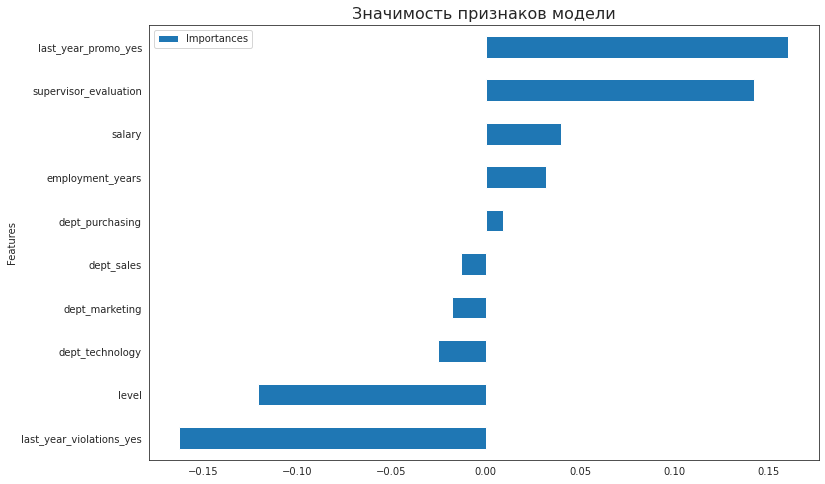

In [59]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':feature_names,'Importances':randomized_search_linear.best_estimator_._final_estimator.coef_})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели',size=16)
plt.show()

Отлично, линейная модель хорошо интепретируется - самыми значимыми признакми оказались -повышение за последний год, оценка супервизопа и зарплата, что логично, нарушение трудового договора сказывается  резко негативно, работник теряет доверие

Посмотрим на лучшую модель - случайные леса. Работает она дольше остальных, зато результат прекрасный.

Разберемся с  случайным деревом решений. 

In [60]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=feature_names

)

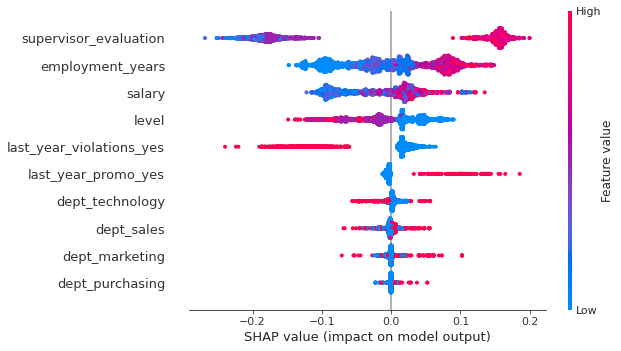

In [61]:
explainer = shap.TreeExplainer(randomized_search_tree.best_estimator_._final_estimator)
shap_values = explainer(X_train_p)
shap.plots.beeswarm(shap_values)

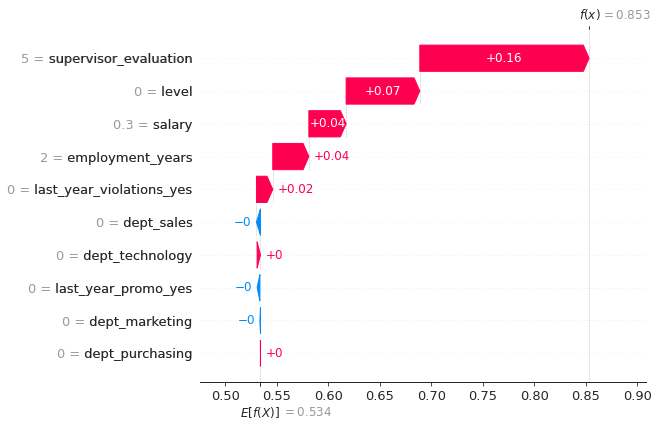

In [62]:
shap.plots.waterfall(shap_values[1])

Интерпретация хорошая, прадва признаковое описание и значимость чуть отличается. Самым большим весом обладает оценка супервизора, далее количество лет (в линейной был малый вес) на должности и зарплата, должность (чем выше, тем стрессовей и ниже оценка), также важно количество нарушений договора и повышение за последний год

Подсчёт значений shap у RandomForest занимает около 3 минут

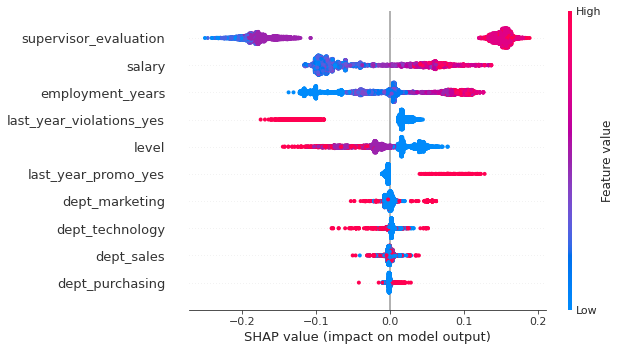

In [63]:
explainer = shap.TreeExplainer(randomized_search_forest.best_estimator_._final_estimator) #Оценка признаков занимает около минуты
shap_values = explainer(X_train_p)
shap.plots.beeswarm(shap_values)

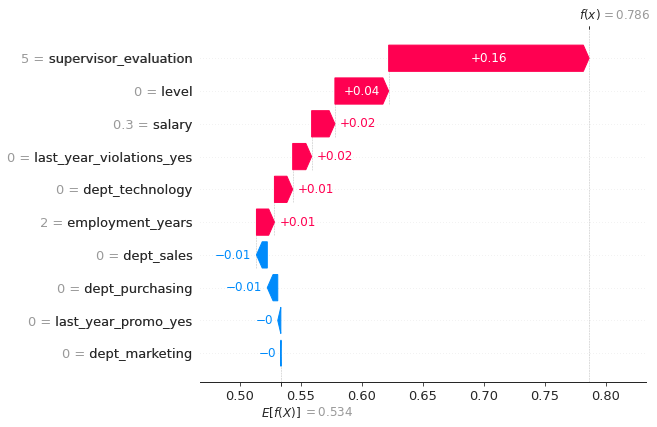

In [64]:
shap.plots.waterfall(shap_values[1])

Оценка значимости признаков совпадает с деревом решений, однако зарплата оказалась значимее количества лет в компании, а уровень работника менее значимым, чем нарушение трудового договора при формировании финальной оценки удовлетворённости 

In [65]:
y_test_pred =randomized_search_forest.best_estimator_.predict(test_data.drop(['job_satisfaction_rate'],axis=1))
print('Метрика SMAPE лучшей модели на тестовой выборке равна', round(smape_unweighted(test_data['job_satisfaction_rate'],y_test_pred),2))

Метрика SMAPE лучшей модели на тестовой выборке равна 12.6


### Выводы по первой задаче

В процессе анализа моделей была найдена лучшая по метрике и интерпретируемости модель - RandomForestRegression, количество деревьев по-умолчанию равно 100 (модель долго обучается и долго считает вклад методом shap), лучший кодировщик MinMaxScaler. Модель отлично интерпретируется - наглядно с помощью библиотеки shap  можно посмотреть на самые значимые признаки, и их вклад при формировании уровня удовлетворённости каждого пользователя. На тестовой метрике значение критерия качества smape достигает 12.6, что удовлетворяет требованию заказчика (SMAPE <= 15) . Можно перехеодить ко второй задаче

# Задача 2: предсказание увольнения сотрудника из компании

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

# Шаг 1. Загрузка данных

In [66]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

In [67]:
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [68]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [69]:
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
test_target_quit.sample(5)

,id,quit
1392,609235,no
1557,572382,no
135,180906,no
590,241319,no
1994,634763,no


Все данные загружены, двигаемся дальше

Выводы:
Все необходимые данные, соответствующие условию задачи загружены. Тренировочная выборка для обучения моделиЮ, содержащая 4 тыс записей о сотрудниках. Также будет использоваться датасет с тестовыми данными, загруженный ранее, а также целевой признак тестовой выборки для оценки качества предсказания лучшей моделью. Можно двигаться дальше


# Шаг 2. Предобработка данных

Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [70]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [71]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [72]:
cols = ['dept','level','workload','last_year_promo','last_year_violations','quit']
for col in cols:
    print(train_quit[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [73]:
train_quit['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

В данных явный дисбаланс, нужно будет его устранять

In [74]:
test_features.sample(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
489298,technology,sinior,low,4,no,no,3,31200
980194,hr,junior,medium,1,no,no,4,22800
565929,marketing,junior,high,1,no,yes,1,39600
497976,technology,middle,medium,3,no,no,4,52800
311666,sales,junior,medium,2,no,yes,3,20400


In [75]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 205.2+ KB


In [76]:
cols = ['dept','level','workload','last_year_promo','last_year_violations']
for col in cols:
    print(test_features[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]
['no' 'yes']
['no' 'yes']


Значения nan заполнятся в пайплайне

In [77]:
test_target_quit.sample(5)

,id,quit
964,781112,yes
1342,753322,no
957,157828,yes
327,462484,yes
1309,586207,yes


In [78]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [79]:
test_target_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

C предобработкой закончили, никаких проблем не выявлено. Замечания - есть явный дисбаланс, и пропуски которые в дальнейшем нужно заполнить - этим мы займёмся в пайплайне, никаких проблем с типом данных и дубликатами не обнаружено

# Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.


3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.


3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

Посмотрим на распределение признаков на тренировочной выборке

In [80]:
train_quit = train_quit.set_index('id')
train_quit.sample(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
808630,technology,junior,medium,1,no,no,2,33600,yes
386852,marketing,middle,low,7,no,no,4,31200,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
228777,sales,middle,low,5,no,no,5,24000,no
950993,hr,middle,high,5,no,no,5,57600,no


In [81]:
bar_cols = ['dept','level','last_year_promo','last_year_violations','employment_years','supervisor_evaluation','workload']

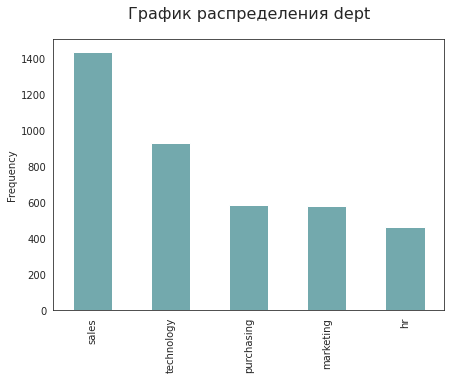

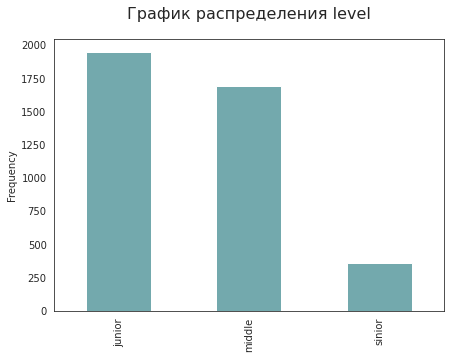

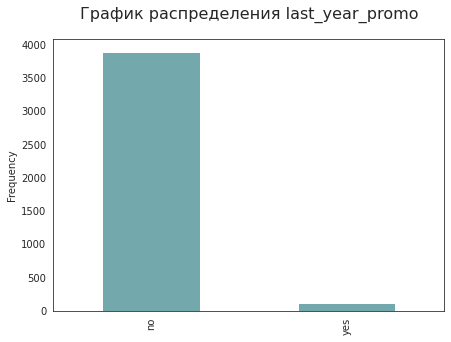

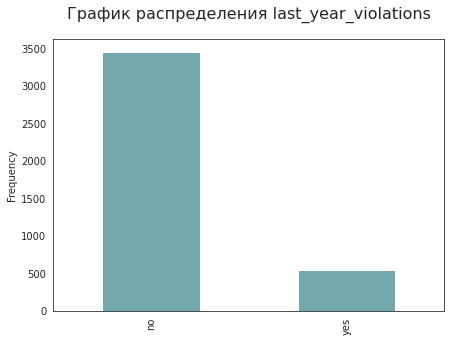

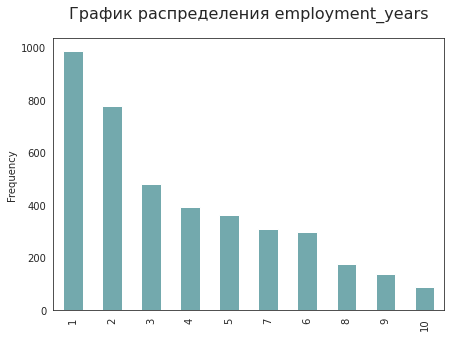

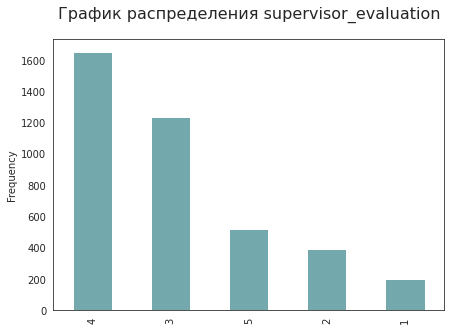

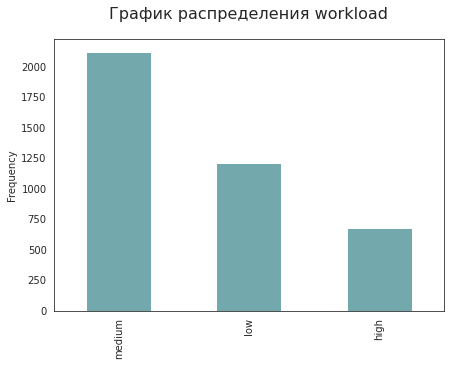

In [82]:
for col in bar_cols:
    train_quit[col].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.ylabel('Frequency')
    plt.show()

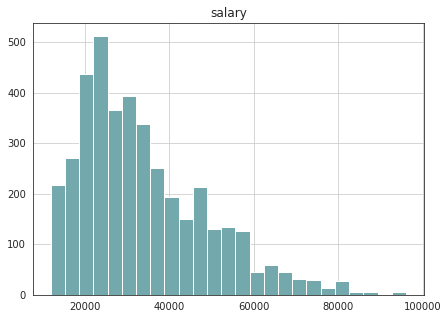

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [83]:
train_quit.hist('salary',figsize=(7,5),color='#73A9AD',bins=25)
plt.show()
print(train_quit['salary'].describe())

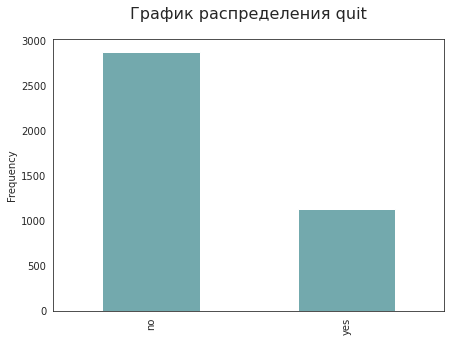

In [84]:
train_quit['quit'].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
plt.title(f'График распределения quit',size=16,pad=20)
plt.ylabel('Frequency')
plt.show()

В целом про тренировочную выборку можно сказать следующее.

* В целевом признаке наблюдается дисбаланс, нужно будет посмотреть матрицу корреляии для каждой группы
* Распределение зп похоже на биномиальное
* На позициях преобладают junior и middle специалисты
* У сотрудников средняя нагрузка
* Самое большое количество сотрудников работает в компании около года

Поработает с портретом типичного уволившегося сотрудника

In [85]:
train_quit_yes = train_quit.query('quit == "yes"')
train_quit_no = train_quit.query('quit == "no"')

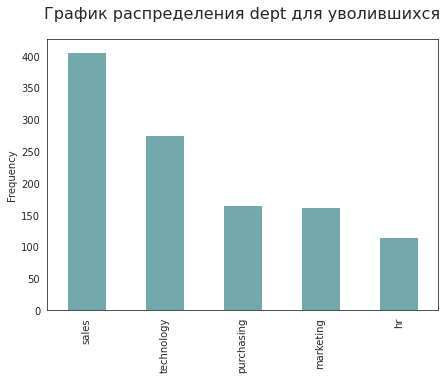

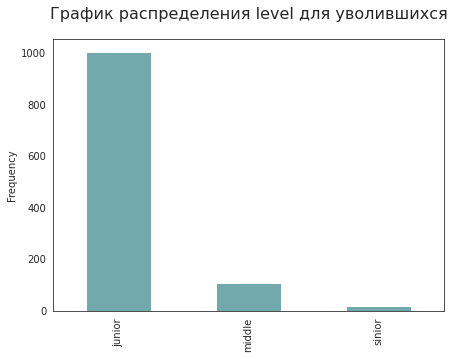

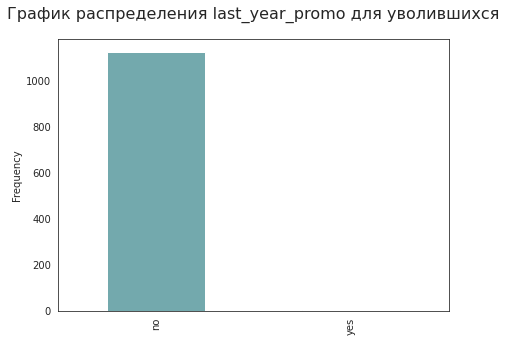

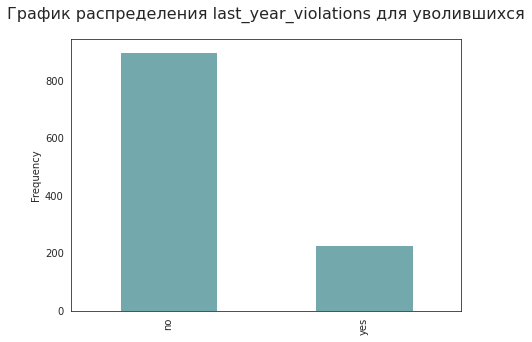

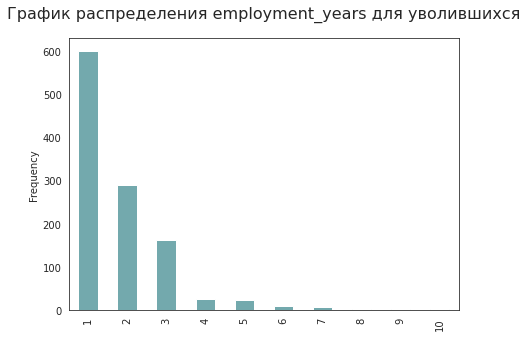

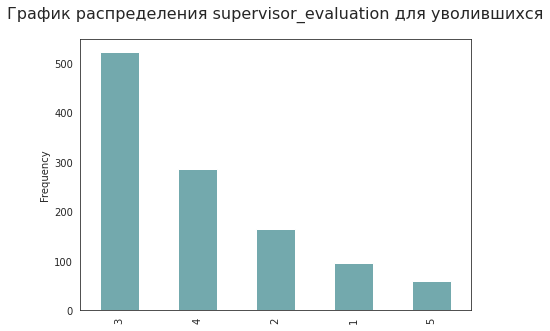

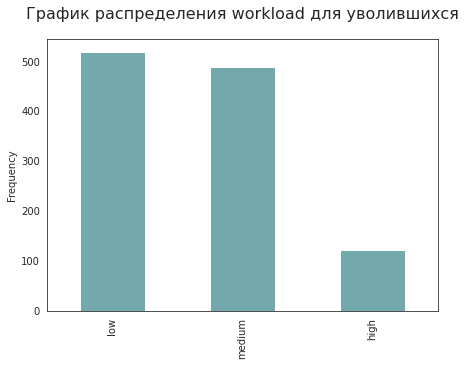

In [86]:
for col in bar_cols:
    train_quit_yes[col].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col} для уволившихся',size=16,pad=20)
    plt.ylabel('Frequency')
    plt.show()

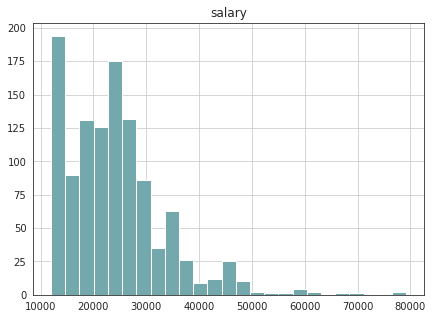

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


In [87]:
train_quit_yes.hist('salary',figsize=(7,5),color='#73A9AD',bins=25)
plt.show()
print(train_quit_yes['salary'].describe())

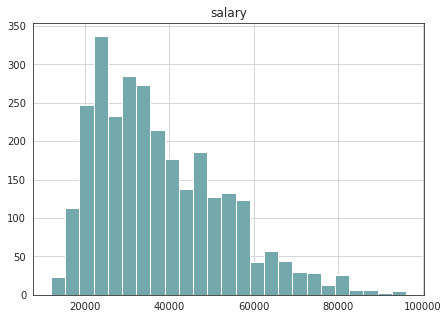

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


In [88]:
train_quit_no.hist('salary',figsize=(7,5),color='#73A9AD',bins=25)
plt.show()
print(train_quit_no['salary'].describe())

На основе данных можно сказать, что типичный уволившийся сотрудник получает зп в районе 24 тыс, находится на стартовой позиции junior, работает меньше двух лет, имеет небольшой уровень загруженности. Оценка от супервизора 3. Не все переживают на работе первый год, поэтому такой отсев, в целом все логично

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [89]:
test_target_quit = test_target_quit.set_index('id')
test_target_quit.head(3)

,quit
id,
999029,yes
372846,no
726767,no


In [90]:
test_data.head()

,dept,level,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,
485046,marketing,junior,2,no,no,5,28800,0.79
686555,hr,junior,1,no,no,4,30000,0.72
467458,sales,middle,5,no,no,4,19200,0.64
418655,sales,middle,6,no,no,4,19200,0.60
789145,hr,middle,5,no,no,5,40800,0.75


In [91]:
quit_test_data = test_data.join(test_target_quit)
quit_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   employment_years       2000 non-null   int64  
 3   last_year_promo        2000 non-null   object 
 4   last_year_violations   2000 non-null   object 
 5   supervisor_evaluation  2000 non-null   int64  
 6   salary                 2000 non-null   int64  
 7   job_satisfaction_rate  2000 non-null   float64
 8   quit                   2000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


In [92]:
quit_test_data.head(3)

,dept,level,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,
485046,marketing,junior,2,no,no,5,28800,0.79,no
686555,hr,junior,1,no,no,4,30000,0.72,no
467458,sales,middle,5,no,no,4,19200,0.64,no


In [93]:
quit_test_data_leave = quit_test_data.query('quit == "yes"')
quit_test_data_stay = quit_test_data.query('quit == "no"')

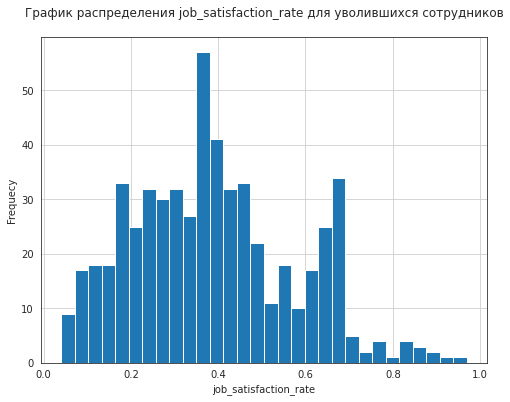

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


In [94]:
quit_test_data_leave['job_satisfaction_rate'].hist(bins=30,figsize=(8,6))
plt.title('График распределения job_satisfaction_rate для уволившихся сотрудников',pad=20)
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Frequecy')
plt.show()
print(quit_test_data_leave['job_satisfaction_rate'].describe())

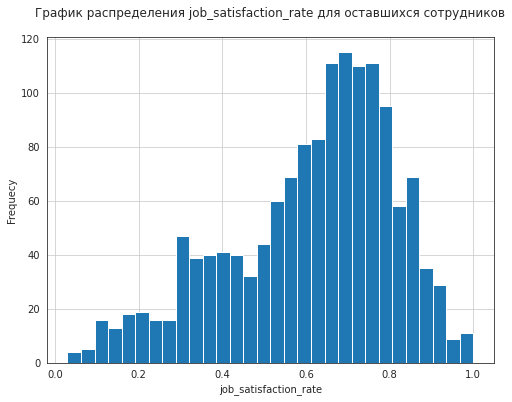

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [95]:
quit_test_data_stay['job_satisfaction_rate'].hist(bins=30,figsize=(8,6))
plt.title('График распределения job_satisfaction_rate для оставшихся сотрудников',pad=20)
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Frequecy')
plt.show()
print(quit_test_data_stay['job_satisfaction_rate'].describe())

В целом так оно и есть, заметно,что среднее значение удовлетворённости уволившегося сотрудника около 0.39, а оставшегося около 0.61, отличие приличное, значит есть связь. Осталось провести корреляционный анализ

Проведём стат тест. Возьмём нулевую гипотезу - равенство средних зп сотрудников оставшихся и уволившихся, альтернативня гипотеза - эти средние не равны (двусторонняя). Возьмём уровень значимости равный 10%

In [96]:
alpha = 0.1

results = ttest_ind(quit_test_data_stay['salary'], quit_test_data_leave['salary'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.899113791378305e-66
Отвергаем нулевую гипотезу


Действительно, средние двух выборок отличаются (средние зп сотрудников уволившихся и оставшихся нельзя считать равными с 10 процентным уровнем значимости)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


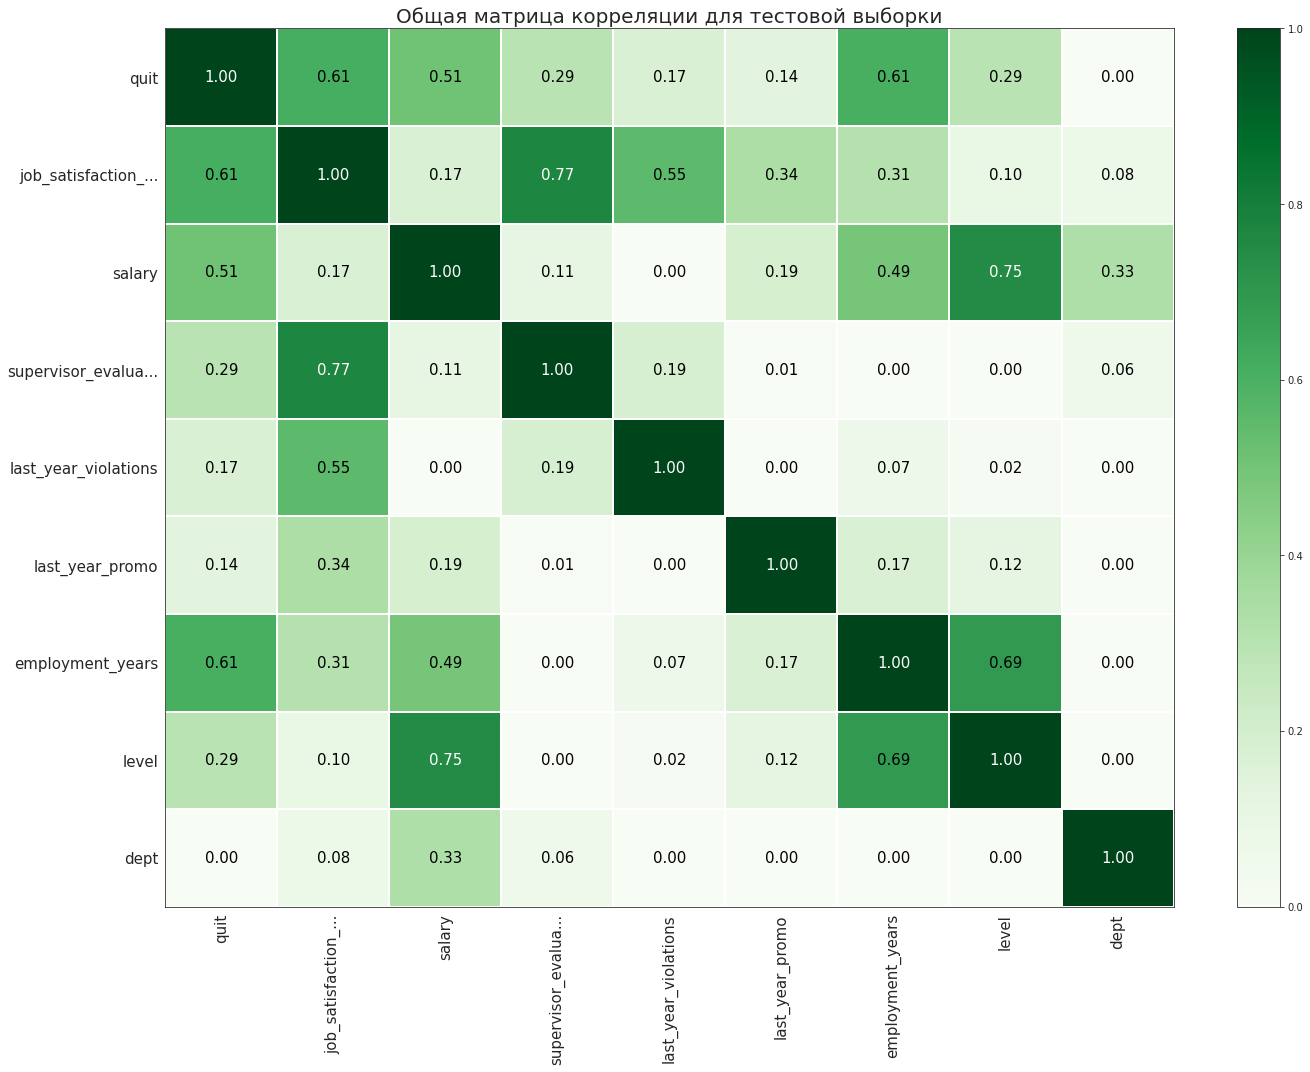

In [97]:
phik_matrix = quit_test_data.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тестовой выборки',size=20)
plt.show()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


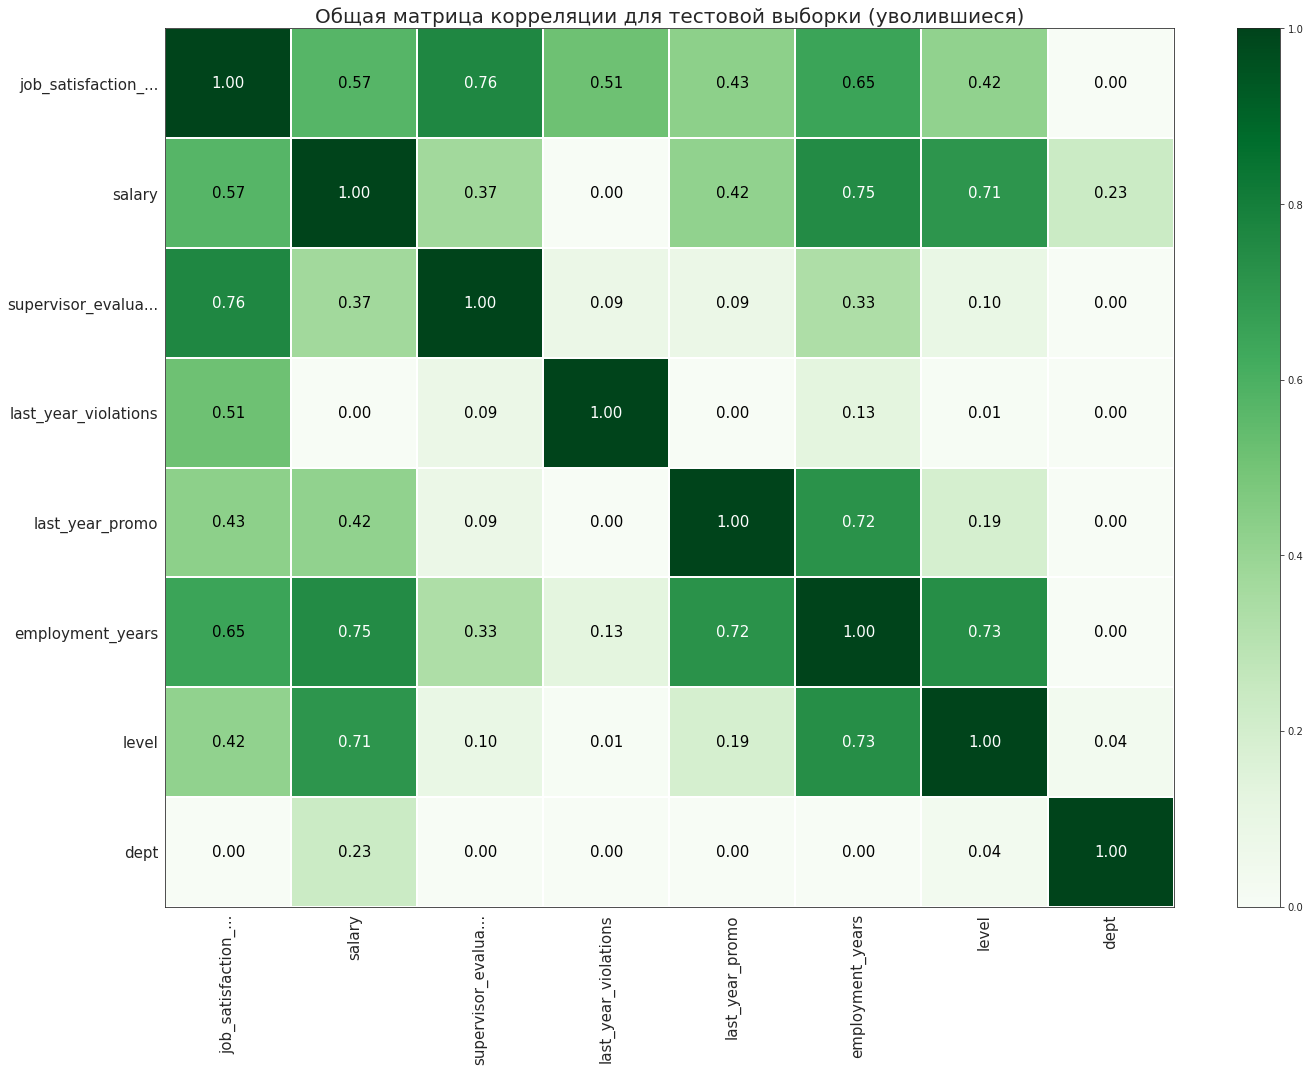

In [98]:
phik_matrix = quit_test_data_leave.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тестовой выборки (уволившиеся)',size=20)
plt.show()

Корреляция между целевым признаком и удовлетворённостью выше среднего, значит взаимосвязь, действительно, есть

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


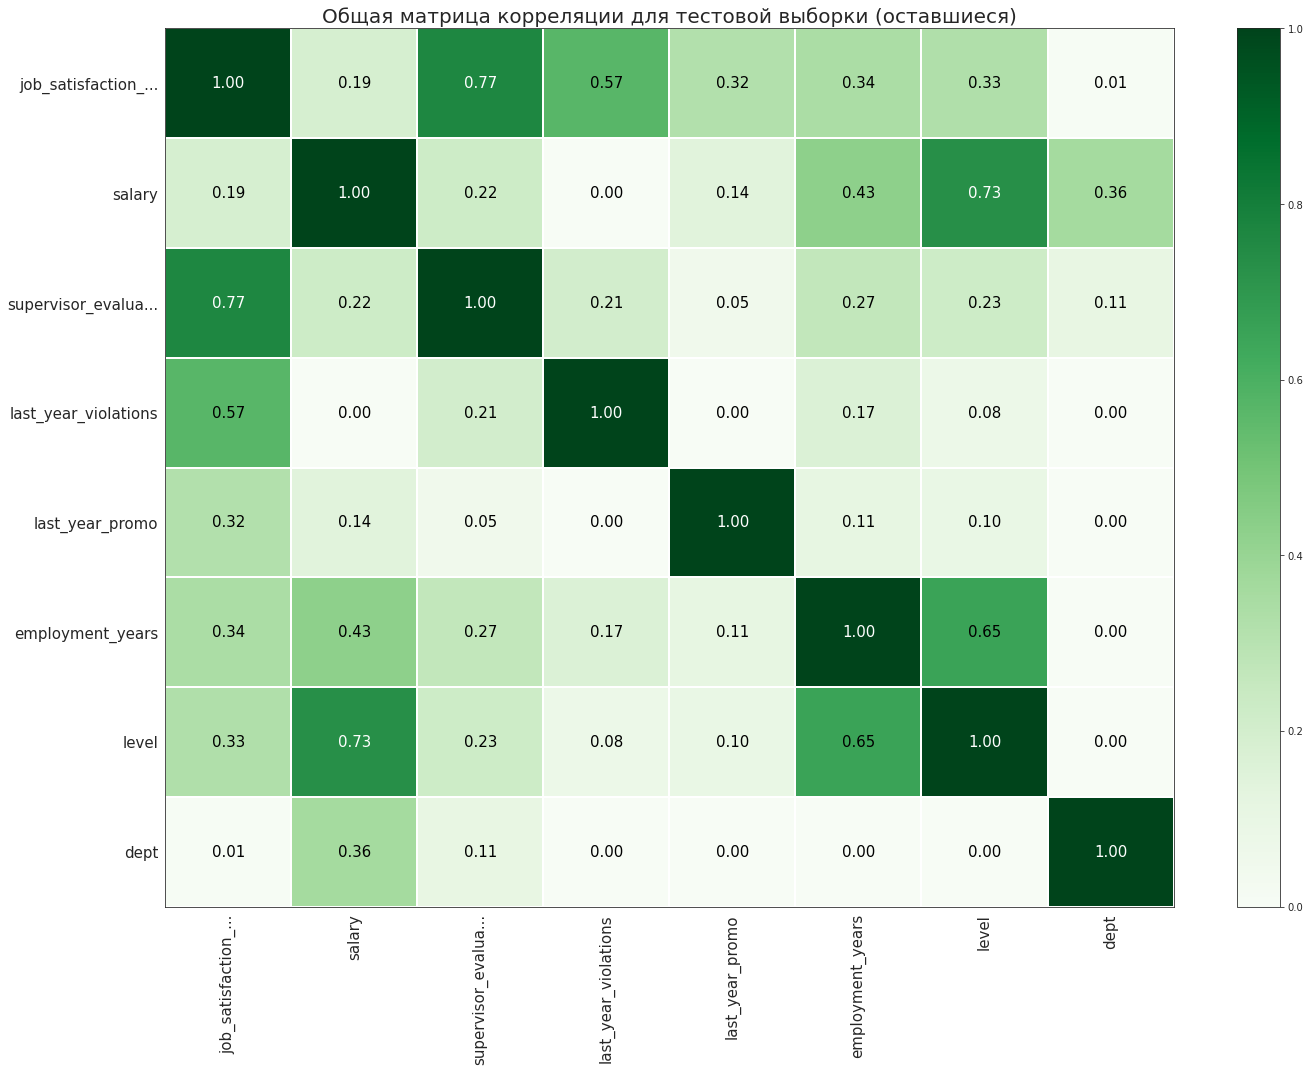

In [99]:
phik_matrix = quit_test_data_stay.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тестовой выборки (оставшиеся)',size=20)
plt.show()

По тестовой выборке ситуация интересная в нескольких признаках есть довольно высокая корреляция, но убирать какие-либо признкки пока не стоит, сделаем это при отборе признаков. Еще один момент корреляция между признаками для уволившихся сотрудников гораздо выше, чем для оставшихся. Например на первом году работы практически никто не получает повышения, и находится чаще всего на стартовой позиции (уволившиеся сотрудники)

Посмотрим на тренировочные данные, ситуация должна быть схожая

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


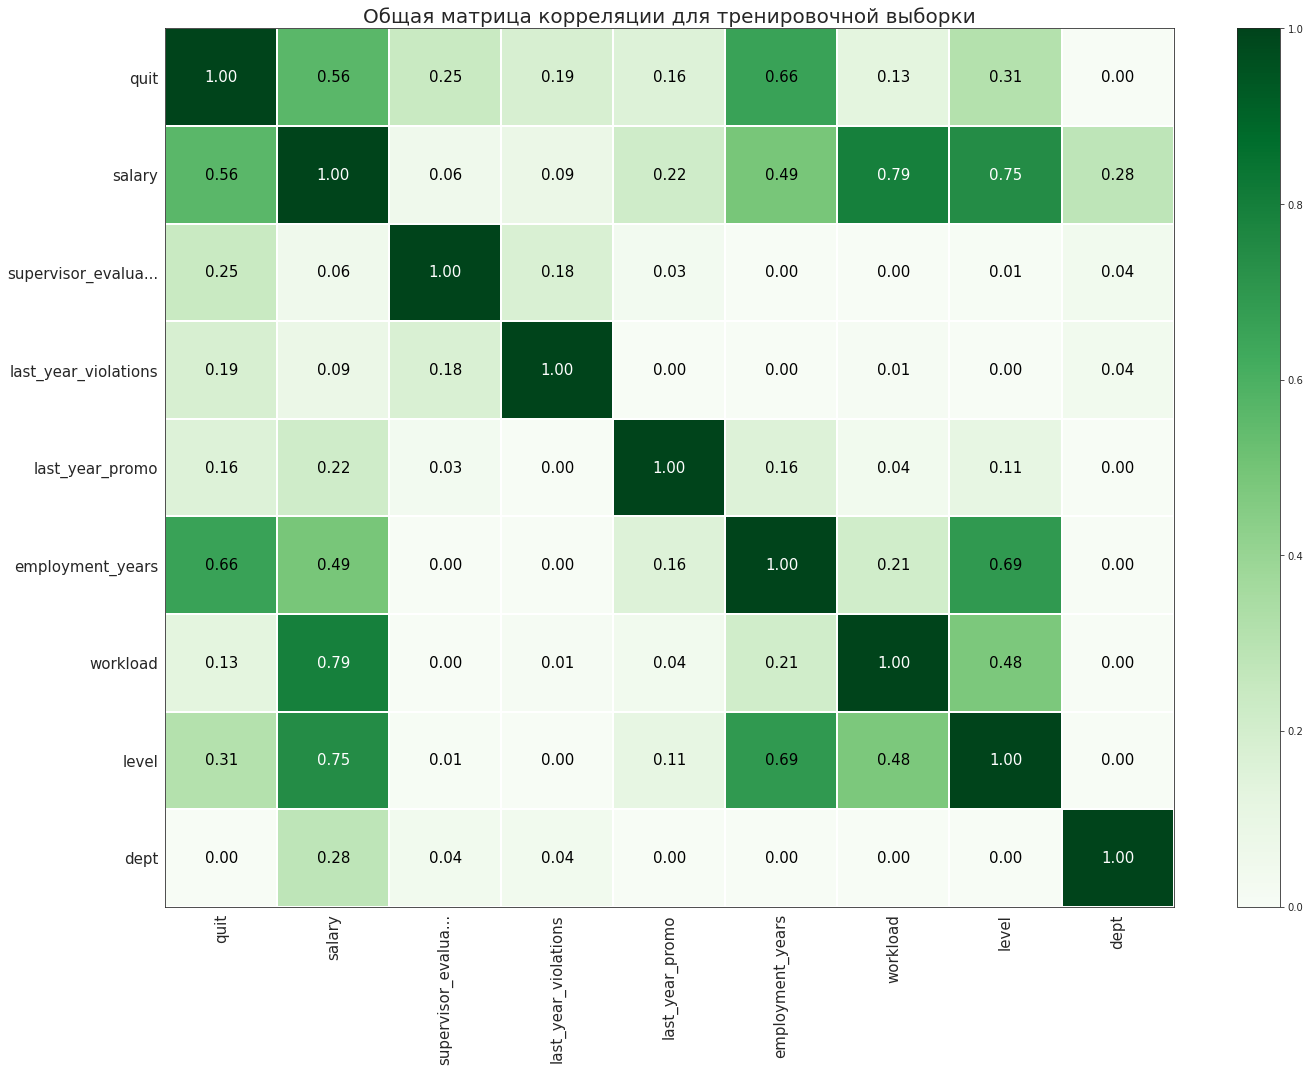

In [100]:
phik_matrix = train_quit.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тренировочной выборки',size=20)
plt.show()

Признак workload пока уберём - явная мультиколлинеарноть с признаком salary

In [101]:
train_quit_without_workload = train_quit.drop(['workload'],axis=1)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


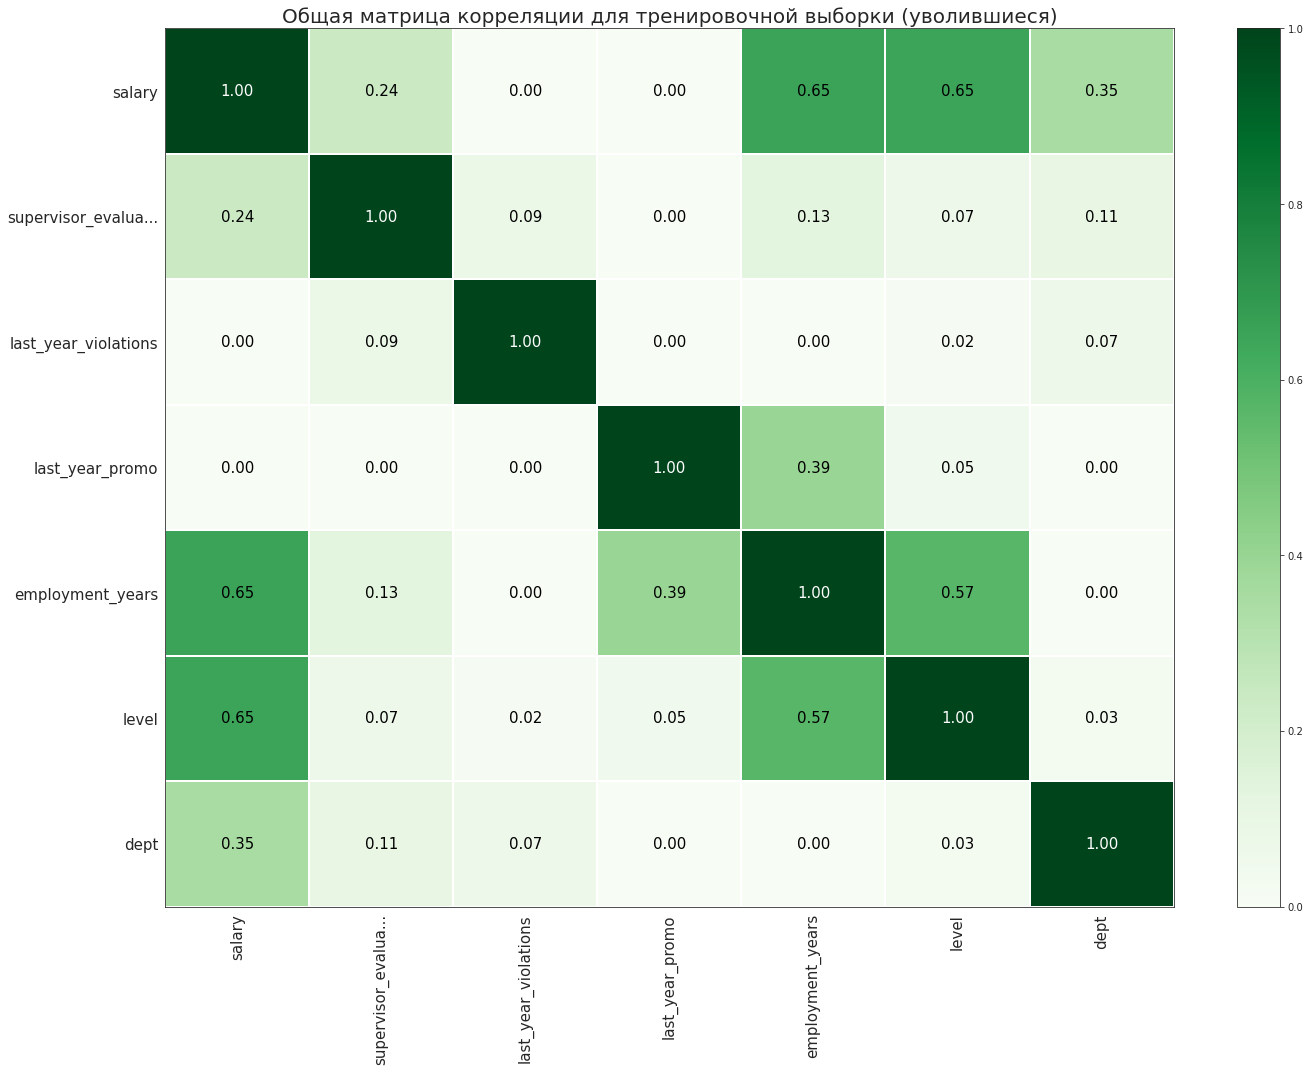

In [102]:
phik_matrix = train_quit_without_workload.query('quit =="yes"').phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тренировочной выборки (уволившиеся)',size=20)
plt.show()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


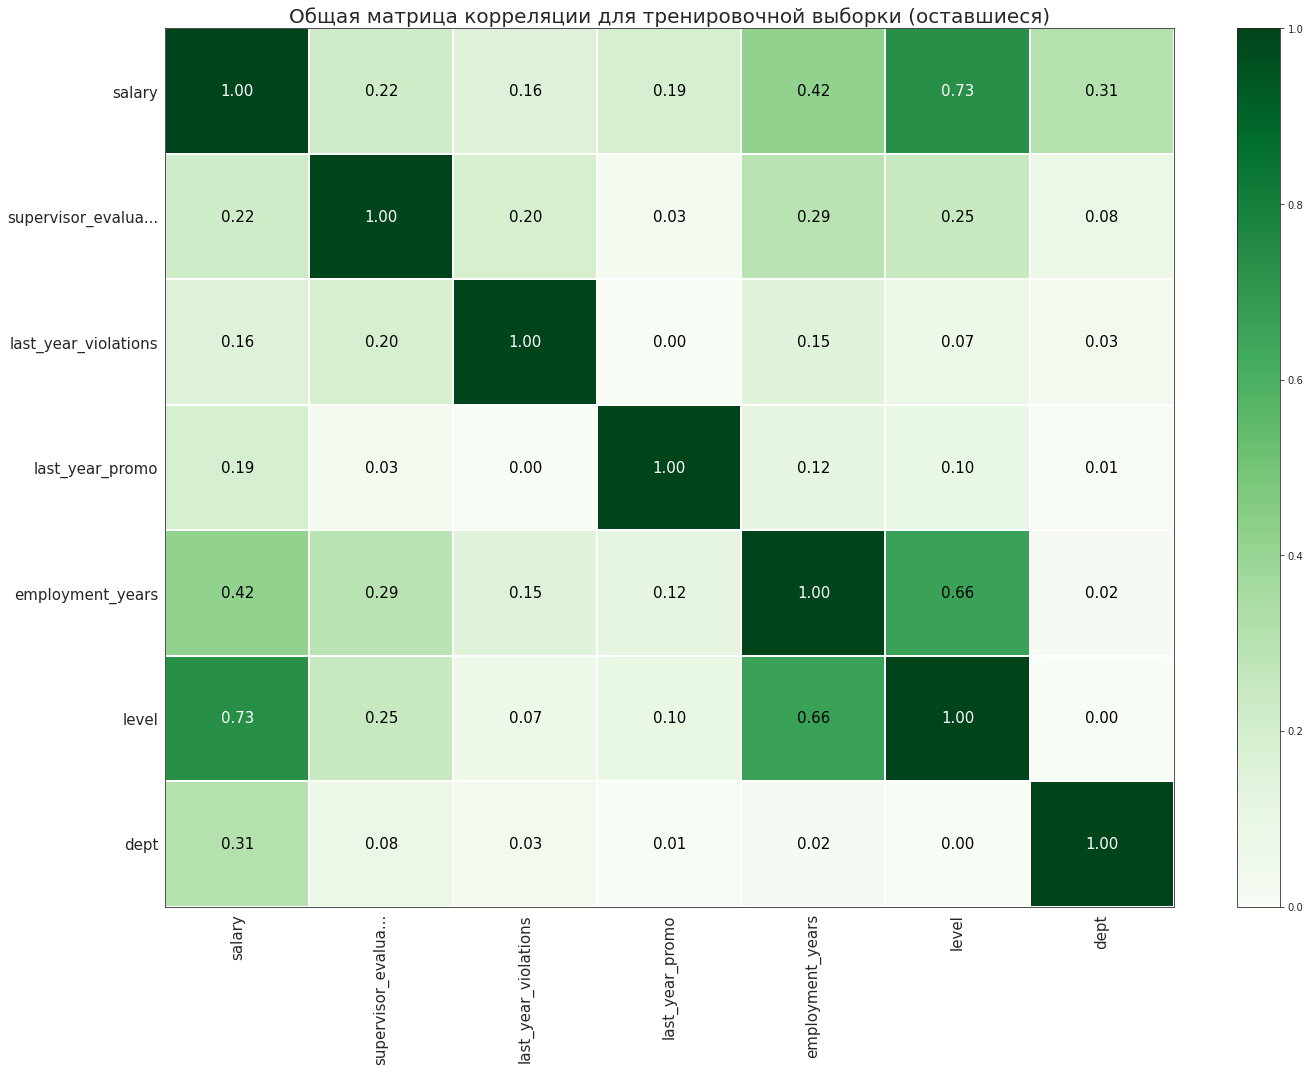

In [103]:
phik_matrix = train_quit_without_workload.query('quit =="no"').phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тренировочной выборки (оставшиеся)',size=20)
plt.show()

#### Выводы по исследовательскому анализу

В процессе исследовательского анализа было выявлено и сделано следующее:
    
* Был составлен типичный портрет уволившегося сотрудника (начальная позиция или стажёр, с небольшой зп, невысокой оценкой от суперивизора)
* Между целевым признаком ухода и удовлетворённостью существует достаточно весомая зависимость (коэффициент корреляции phik равен 0.56 на тестовой выборке)
* Из тестовой и тренировочной выборке изъят признак workload, который сильно коррелирует с уровнем зарплаты
* Между остальными признаками тоже существует весомая корреляция, но дальнейшие манипуляции по отбору я буду делать в процессе насйтроки и обучения моделей
* У уволившихся сотрудников корреляция на тестовой выборке заметно выше, чем у отавшихся
* По целевому признаку есть дисбаланс, который стоит учесть при обучении моделей

In [104]:
analysis_data = train_quit
analysis_data['QUIT'] =  analysis_data['quit'] == 'yes'

In [105]:
comparison_cols = ['dept','level','last_year_violations','supervisor_evaluation','last_year_promo']

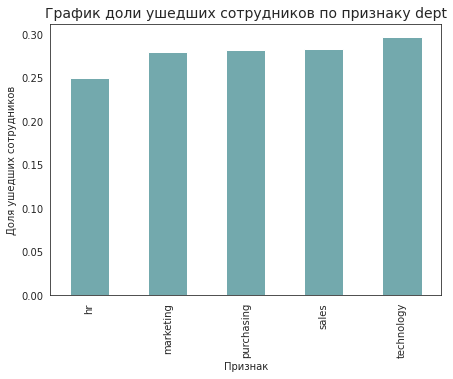

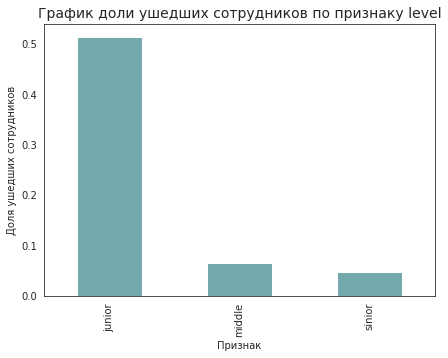

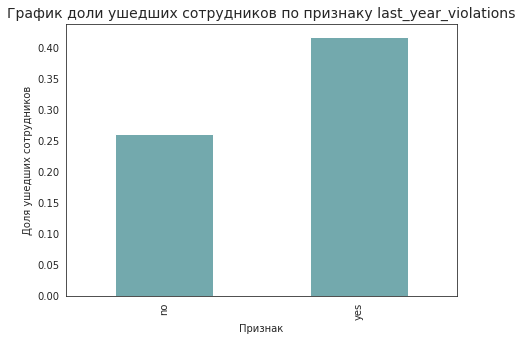

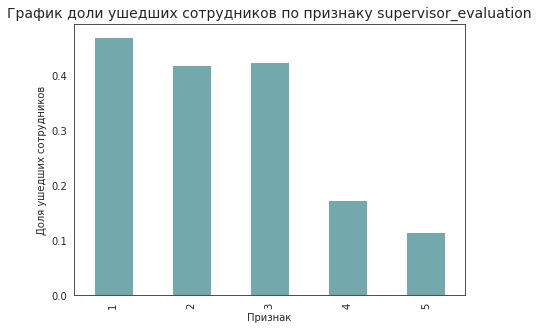

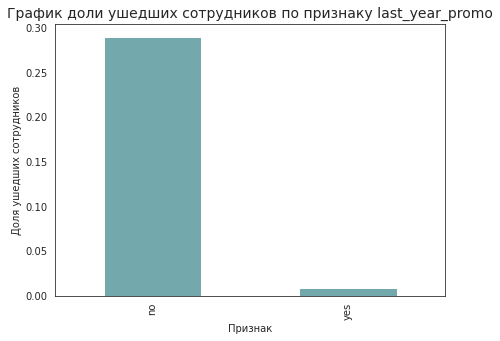

In [106]:
for col in comparison_cols:
    data = analysis_data.groupby(col)['QUIT'].sum()/train_quit.groupby(col)['QUIT'].count()
    data.plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.ylabel('Доля ушедших сотрудников')
    plt.xlabel('Признак')
    plt.title(f'График доли ушедших сотрудников по признаку {col}',size=14)
    plt.show()

Благодаря построению графиков доли ушедших сотрудников по признакам, можно сделать первичный вывод - меньше всего людей покидает hr отдел, больше всего - отдел technology. Около половины сотрудников на позиции junior уходят с работы, такжже более 40 % людей, получившие от начальства низкую оценку покидают работу. Чтобы удержать сотрудника можно предложить ему повышение, процент ушедших сотрудников, получивших повышение, очень низкий

# Шаг 4. Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [107]:
train_quit_without_workload['job_satisfaction_rate'] =randomized_search_forest.best_estimator_.predict(train_quit_without_workload.drop(['quit'],axis=1))

In [108]:
train_quit_without_workload.head()

,dept,level,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,2,no,no,4,54000,no,0.635667
814010,sales,junior,2,no,no,4,27600,no,0.825551
155091,purchasing,middle,5,no,no,1,37200,no,0.375392
257132,sales,junior,2,no,yes,3,24000,yes,0.354267
910140,marketing,junior,2,no,no,5,25200,no,0.761843


interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


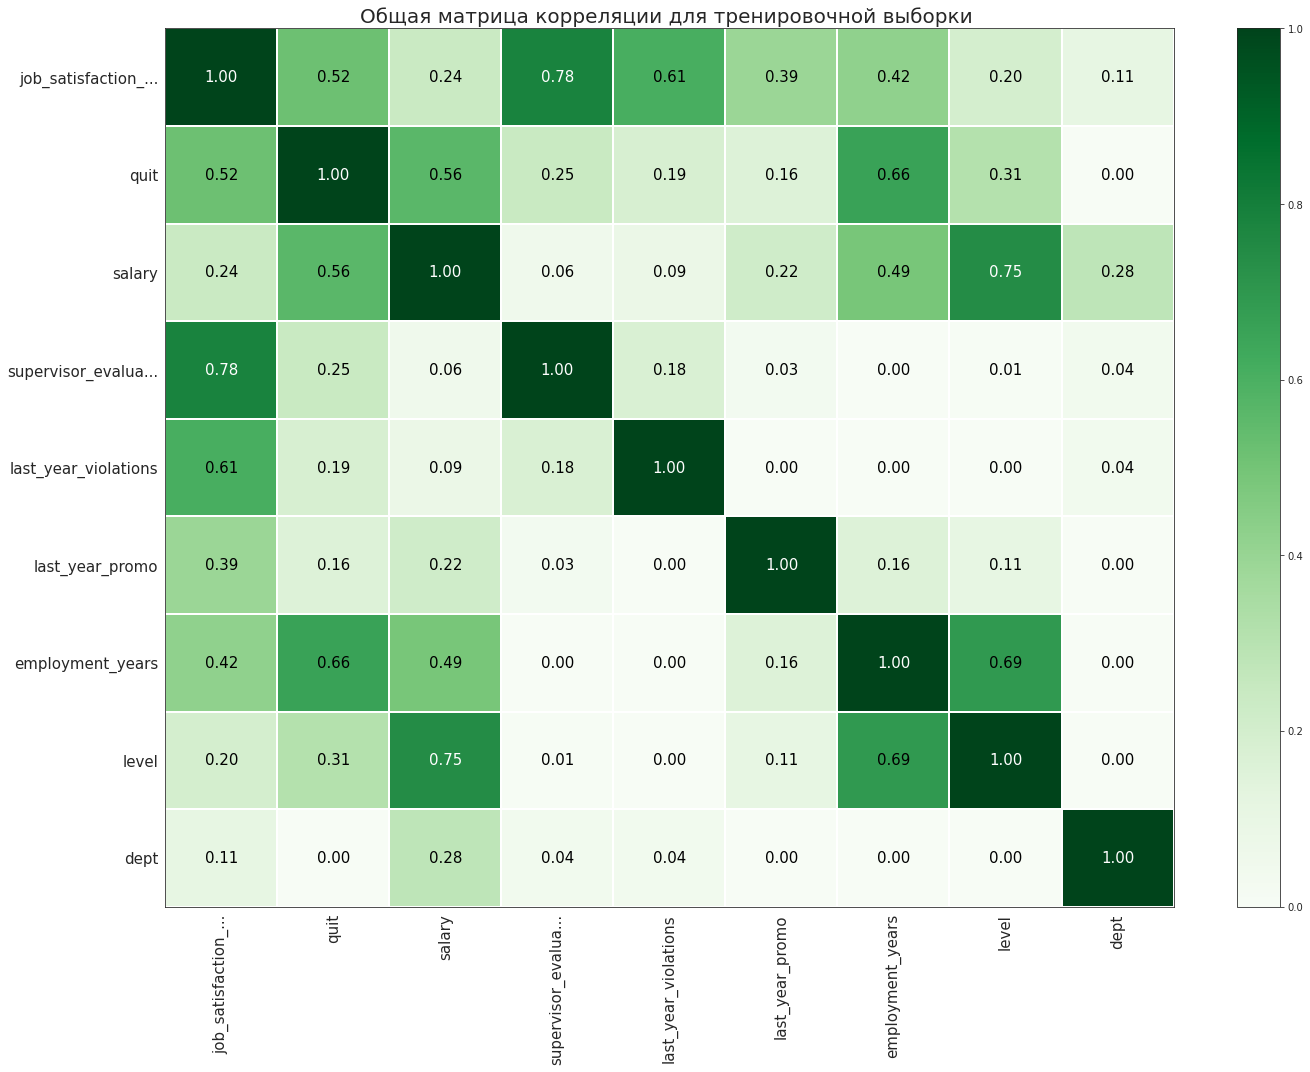

In [109]:
phik_matrix = train_quit_without_workload.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции для тренировочной выборки ',size=20)
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошо, признак job_satisfaction_rate добавлен в тренировочную и тестовую выборки, а значения предсказаны с помощью лучшей модели регрессии, обученной в прошлой части задачи

# Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

При классификации лучше закодировать целевой признак с помощью labelencoder

In [110]:
X_train = train_quit_without_workload.drop(['quit'],axis=1)
y_train = train_quit_without_workload['quit']

In [111]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(label_encoder.classes_,'->',label_encoder.transform(['no','yes']))


['no' 'yes'] -> [0 1]


In [112]:
final_test_y = label_encoder.transform(quit_test_data['quit'])

Признак job_satisfaction_rate можно не масштабировать, его значение, находится в пределах от 0 до 1

In [113]:
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level']
num_columns = ['salary']
#Кодировщик номинальных категориальных признаков
ohe_pipe = Pipeline(
[
    ('simpleImputer_ohe',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',sparse=False))
    
])

#Кодировщик ранговых категориальных признаков
ord_pipe = Pipeline(
[
    ('simpleImputer_before_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('ord',OrdinalEncoder(categories=[
        ['junior','middle','sinior']
    ],handle_unknown='use_encoded_value',unknown_value=np.nan)),
    ('simpleImputer_after_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
])

#Пайплайн предобработки данных
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)
],
remainder='passthrough')


# Шаг 6. Обучение модели

Создадим и обучим несколько моделей классификации, не забудем про дисбаланс классов, используем, где возможно взвешенные классы, параметр сlass_weight = balanced

In [114]:
pipe_final = Pipeline(
[
    ('preprocessor',data_preprocessor),
    ('models',LogisticRegression( random_state=RANDOM_STATE, 
            solver='liblinear',class_weight='balanced'))
])

param_distr = [
    {
    'models' :[LogisticRegression( random_state=RANDOM_STATE, 
            solver='liblinear',class_weight='balanced')],
    'models__penalty':['l1','l2'],
    'models__C':range(1,50),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
        
    },

    { 'models': [SVC(random_state=RANDOM_STATE,class_weight='balanced')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__gamma':range(1,20)

     },

    {
      
    'models':[KNeighborsClassifier()],
    'models__n_neighbors':range(1,20),
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),RobustScaler()]  
    },
    
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced')],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]



In [115]:
randomized_search = RandomizedSearchCV(
pipe_final,
param_distributions=param_distr,
scoring='roc_auc',
random_state=RANDOM_STATE,
n_jobs=-1)

randomized_search.fit(X_train,y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                              

В целом значение метрики проходит пороговое, но можно попробовать его улучшить, сделав отбор признаков и посмотрев на метрику при помощи KBest. Но сначала посмотрим на важность признаков

In [116]:
coeffs = randomized_search.best_estimator_._final_estimator.coef_
feature_names += ['job_satisfaction_rate']

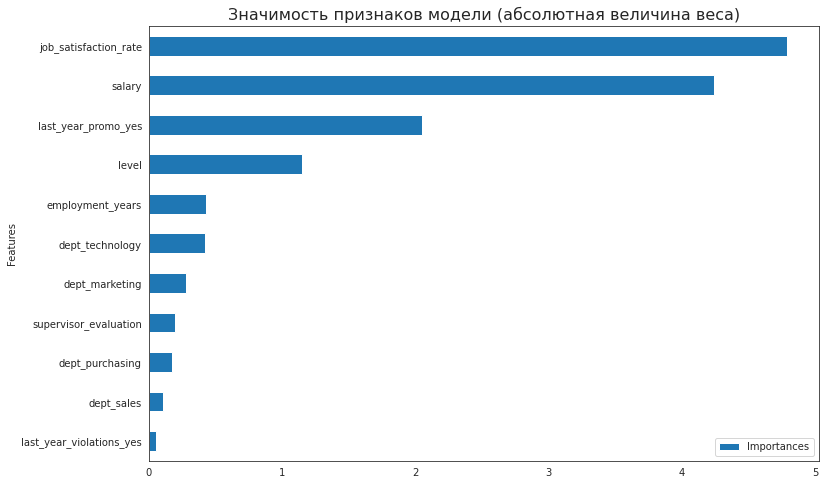

In [117]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':feature_names,'Importances':np.abs(coeffs[0])})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели (абсолютная величина веса)',size=16)
plt.show()

In [118]:
feature_importances

,Features,Importances
5,last_year_violations_yes,0.054871
2,dept_sales,0.105013
1,dept_purchasing,0.173418
9,supervisor_evaluation,0.191833
0,dept_marketing,0.278874
3,dept_technology,0.417792
8,employment_years,0.426519
6,level,1.147551
4,last_year_promo_yes,2.048024
7,salary,4.241809


Теперь попробуем воспользоваться KBest

In [119]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=feature_names

)

Text(0.5, 1.0, 'График зависимости метрики roc_auc при кросс_валидации на тренировояной выборке в зависимости от количества признаков')

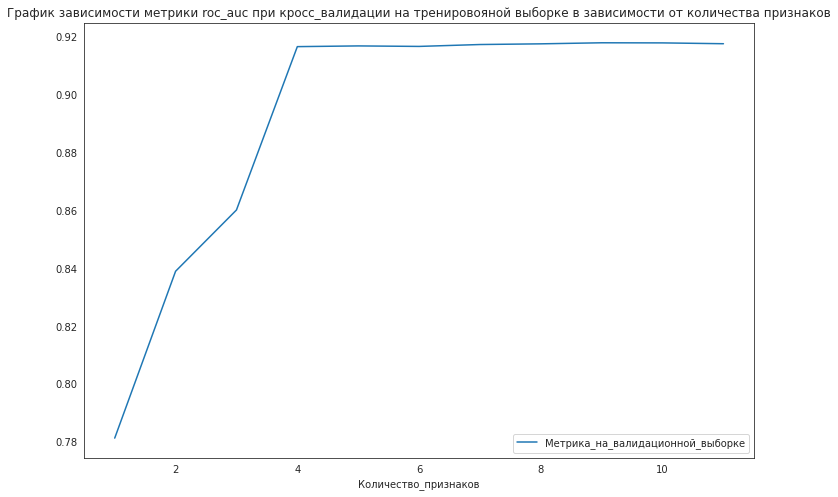

In [120]:
res = {'Количество_признаков':[],'Метрика_на_валидационной_выборке':[]}
for i in range(1,12):
    selector = SelectKBest(f_classif,k=i)
    model =  LogisticRegression(C=14, class_weight='balanced',random_state=42, solver='liblinear')
    selector.fit(X_train_p,y_train)
    features_names = X_train_p.columns[selector.get_support(indices=True)]
    X_train_new = X_train_p[list(features_names)]
    r = cross_val_score(model,X_train_new,y_train,cv=5,scoring='roc_auc')
    res['Количество_признаков'].append(i)
    res['Метрика_на_валидационной_выборке'].append(r.mean())
result = pd.DataFrame(res)
result.plot(x='Количество_признаков',y='Метрика_на_валидационной_выборке',figsize=(12,8))
plt.title('График зависимости метрики roc_auc при кросс_валидации на тренировояной выборке в зависимости от количества признаков')

In [121]:
result

,Количество_признаков,Метрика_на_валидационной_выборке
0,1,0.781366
1,2,0.839012
2,3,0.860176
3,4,0.916609
4,5,0.916856
5,6,0.916684
6,7,0.917338
7,8,0.917576
8,9,0.917940
9,10,0.917901


Оптимальное значение на валидационной выборке при 8 признаках, посмотрим на самые значимые признаки

Значение метрики roc_auc при кросс валидации равно 0.9175756966831251
Количество признаков равно 8


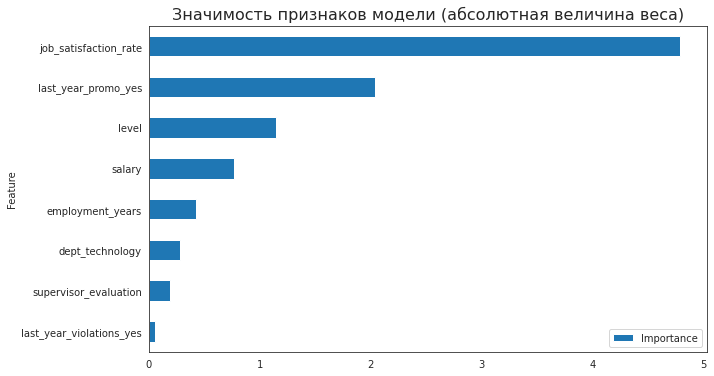

In [122]:
selector = SelectKBest(f_classif,k=8)
model =  LogisticRegression(C=14, class_weight='balanced',random_state=42, solver='liblinear')
selector.fit(X_train_p,y_train)
features_names = X_train_p.columns[selector.get_support(indices=True)]
X_train_new = X_train_p[list(features_names)]
r = cross_val_score(model,X_train_new,y_train,cv=5,scoring='roc_auc')
model.fit(X_train_new,y_train)
print(f'Значение метрики roc_auc при кросс валидации равно {r.mean()}')
print(f'Количество признаков равно 8')

    
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance',ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Значимость признаков модели (абсолютная величина веса)',size=16)
plt.show()

В целом лучшая модель с лучшим количетсво признаков найдена, проверим метрику на тестовой выборке

In [123]:
X_final_test = pd.DataFrame(
    data_preprocessor.transform(quit_test_data.drop(['quit'],axis=1)),
     columns=feature_names
   
) 

X_final_test = X_final_test[list(features_names)]

In [124]:
y_test_pred = model.predict_proba(X_final_test)
print(f'Значение метрики roc_auc финальной модели на тестовой выборке равно {roc_auc_score(final_test_y,y_test_pred[:,1])}')



Значение метрики roc_auc финальной модели на тестовой выборке равно 0.9115555670795551


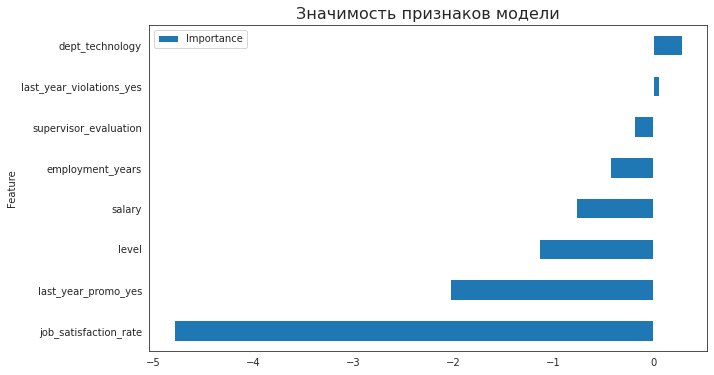

In [125]:
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance',ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Значимость признаков модели',size=16)
plt.show()

Сделаем еще один небольшой доп анализ, чтобы посмотреть, а какой класс предсказывает модель лучше

In [126]:
y_test_p = model.predict(X_final_test)

In [127]:
f1_score(final_test_y,y_test_p)

0.7381132075471698

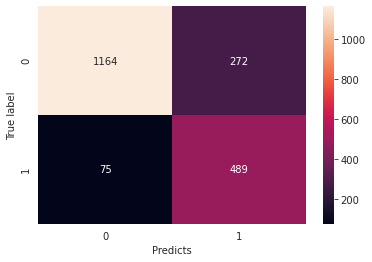

In [128]:
cm = confusion_matrix(final_test_y,y_test_p)
sns.heatmap(cm,annot=True,fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicts')
plt.show()

В целом модель одинаково педсказывает оба класс - это хорошо (нам важен класс ушедших, а он меньше)

# Шаг 7. Выводы

В процессе работы над второй задачей я нашёл лучшую модель, которая предсказывает вероятность ухода сотрудника из компании (задача классификации)

В процессе работы я провел предобработку данных, провёл исследовательский и корреляционный анализ данных, далее обучил несколкьо иоделей и нашел с помощью пайплайнов лучшую.

Оказалось, что лучшей моделью для данной задачи псолужила модкль логистической регрессии с ядром liblinear, коэффициентом регуляризации 14 и ввзешенными классами. Модель показала на тестовой выборке метрику roc_auc выше 0.91.

При отборе было выделено 8 основных признаков вляющих на поведение модели
* Уровень удовлетворенности работника
* Повышение за последний год
* Должность 
* Зарплата
* Нарушение договора (негативно)
* Отдел технологий (негативно)

Вероятно логистическая регрессия справилась лучше из-за высокой корреляции между целевых и входными признаками, лучшим кодировщиком оказался MinMaxScaler

# Общий вывод

В процессе работы над проектом мной были выполнены две задачи

Первая - предсказание удовлетворённости сотрудника. Задачу я решал в несколько этапов - загрузка данных их предобработка, исследовательский и корреляционный анализ, далее сотсавление пайлпайна, обучение и отбор лучшей модели, её тестирование и интерпретация. Лучшей моделью оказалась модель RandomTreeForest - это модель  подходит и для регрессии (ансамбль рещающих деревьев). Эта модель показала лучшую метрику на данных и хоорошо интерпретировалась. Самыми значимвми признаками оказались:
* Оценка руководителя (положительно)
* Зарплата (положительно)
* Должность
* Количество лет в компании (положительно)
* Нарушение договора (негативно)

Вторая задача - предсказание ухода сотрудников была задачей классификацией, выполнялась схожим образом, оценка осуществлялась с помощью метрики roc_auc. При решение задачи лучше оказалась модель логистической регрессии с взвешенными классами, коэффициентом регуляризации равным 14 и ядром liblinear. На тестовой выборке модель опказала выскокое качесвто более 0.91. При интерпретации основополагающим признаком оказался уровень удовлетворённости сотрудника (что логично, он складывается из признаков, которые описаны выше), также значимыми для ухода оказались повышение и должность, а вот негативные признаки - нарушение договора и отдел технологий

На основе данного исследования можно сделать следующе рекомендации заказчику:
Больше всего уходов происходит в сегменте новый сотрудник - их большое количество и уходов много - эьл чаще всего люди на позиции junior, работающие в компании около года и имеющие небольшую зп, оценка руководителя в основном 3, из-за них возникает текучка. Также сотрудники на должности sinior бываеют недовольны, возможно на них сваливаются доп обязанности, нужно это узнать.

Для удержания сотрудников важным фактором оказывается позиция и оценка начальства и руководства, возможно, можно вводить меры психологической поддержки для начинающих специалистов, хотя такие меры не помешвют людям на высоких должностях. Также нужно отдельно посмотреть на отдел технологий, почему-то там люди чаще недовольны работой, чем в остальных отделах. Хорошим стимулом для того, чтобы удкржать сотрудника является его повышение и поднятие зп.